<a href="https://colab.research.google.com/github/NuttakitDW/kbtg_data/blob/master/version5_89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [96]:
#version 4
data = pd.read_csv('https://raw.githubusercontent.com/NuttakitDW/kbtg_data/master/train_data_v4.csv')
test_X = pd.read_csv('https://raw.githubusercontent.com/NuttakitDW/kbtg_data/master/test_data_v4.csv')
data.head()

,id,gender,ocp_cd,age,income,kp_txn_count,kp_txn_amt,cd_ex,cc_month_mean,kp_month_mean
0,1,2,9.0,5,20000,2.0,3500.0,44700.0,11175.0,3.500000e+03
1,2,2,3.0,4,106000,104.0,210000.0,65200.0,14385.0,3.500000e+04
2,3,2,1.0,3,29000,70.0,139700.0,0.0,0.0,2.328333e+04
3,4,2,3.0,5,61000,315.0,6076100.0,770000.0,500000.0,1.012683e+06
4,5,2,9.0,4,18000,0.0,0.0,12000.0,6000.0,0.000000e+00


In [97]:
data['overall'] = data['kp_txn_amt'] + data['cd_ex']
data.head()

,id,gender,ocp_cd,age,income,kp_txn_count,kp_txn_amt,cd_ex,cc_month_mean,kp_month_mean,overall
0,1,2,9.0,5,20000,2.0,3500.0,44700.0,11175.0,3.500000e+03,48200.0
1,2,2,3.0,4,106000,104.0,210000.0,65200.0,14385.0,3.500000e+04,275200.0
2,3,2,1.0,3,29000,70.0,139700.0,0.0,0.0,2.328333e+04,139700.0
3,4,2,3.0,5,61000,315.0,6076100.0,770000.0,500000.0,1.012683e+06,6846100.0
4,5,2,9.0,4,18000,0.0,0.0,12000.0,6000.0,0.000000e+00,12000.0


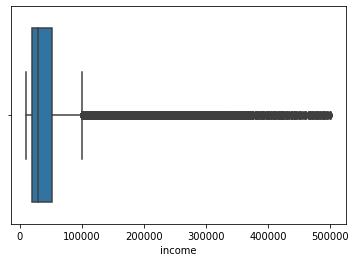

In [98]:
import seaborn as sns
sns.boxplot(x=data['income'])

In [0]:
test_X['overall'] = test_X['kp_txn_amt'] + test_X['cd_ex']

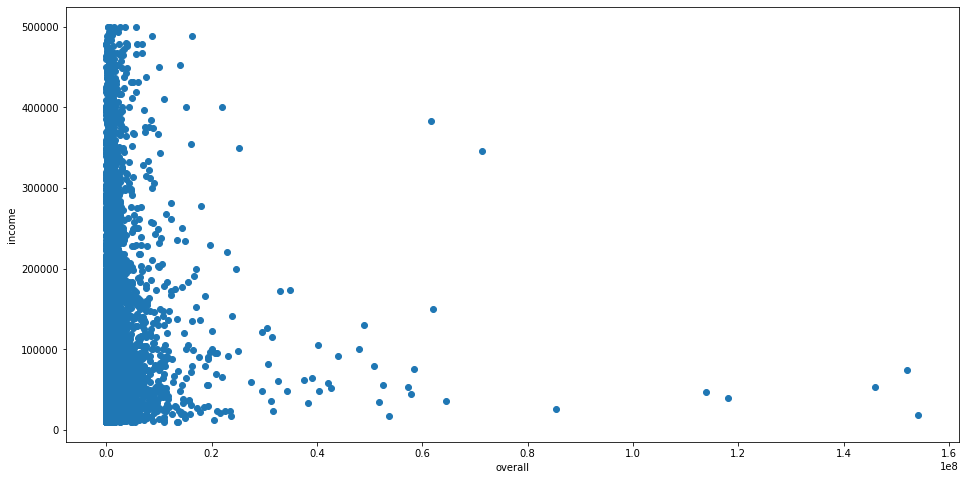

In [121]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(data['overall'], data['income'])
ax.set_xlabel('overall')
ax.set_ylabel('income')
plt.show()

In [0]:
data_im = data.copy()

In [0]:
#remove outlier by remove data that have overall > 0.6e8 & income > 3e5
indexNames = data_im[((data['income'] > 3e5) & (data['overall'] > 0.4e8))].index
data_im.drop(indexNames , inplace=True)

In [146]:
indexNames2 = data_im[data['overall'] > 0.8e8].index
data_im.drop(indexNames2 , inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


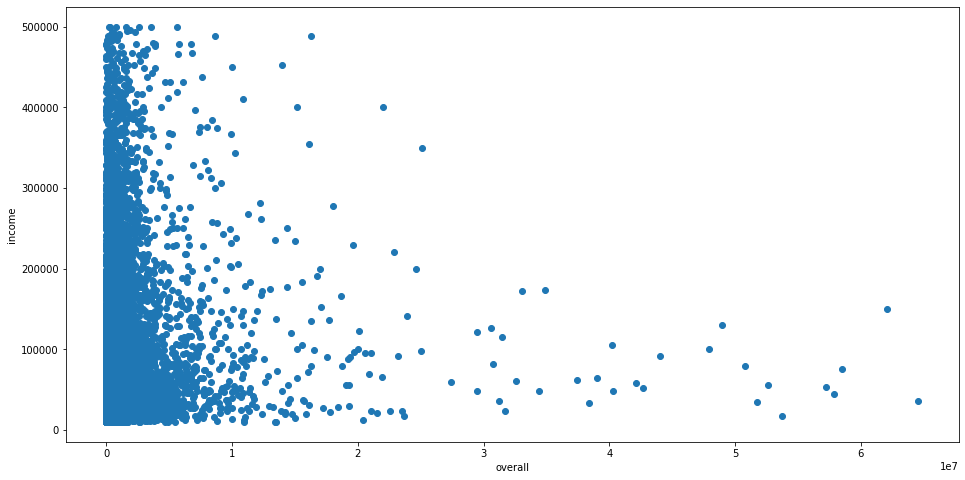

In [147]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(data_im['overall'], data_im['income'])
ax.set_xlabel('overall')
ax.set_ylabel('income')
plt.show()

In [0]:
y = data.income
X = data.drop(['income'], axis=1)
feature = ['ocp_cd', 'age', 'cd_ex', 'kp_txn_amt', 'kp_txn_count', 'gender', 'cc_month_mean', 'kp_month_mean', 'overall']
X = X[feature]

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

categorical_cols = [cname for cname in ['ocp_cd', 'age', 'gender']]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full.copy()
X_valid = X_valid_full.copy()

In [0]:
y = data_im.income
X = data_im.drop(['income'], axis=1)
feature = ['ocp_cd', 'age', 'cd_ex', 'kp_txn_amt', 'kp_txn_count', 'gender', 'cc_month_mean', 'kp_month_mean', 'overall']
X = X[feature]

X_train_full2, X_valid_full2, y_train2, y_valid2 = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
X_train2 = X_train_full2.copy()
X_valid2 = X_valid_full2.copy()

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [0]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42, 
                             learning_rate=0.01, gamma=0.3, max_depth=10, 
                             colsample_bytree=1, subsample=0.7, reg_alpha=0, reg_lambda=3,
                             min_child_weight=7, n_estimators=250
                             )

In [153]:
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', xgb_model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train2, y_train2)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:50:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 21557.573957226563


MAE: 21557.573957226563


Learning Rate:  0.01
Gamma:  0.3
Max Depth:  10
Subsample:  0.7
Max Features at Split:  1.0
Alpha:  0
Lamda:  3
Minimum Sum of the Instance Weight Hessian to Make a Child:  7
Number of Trees:  250



In [0]:
res = my_pipeline.predict(test_X[feature])

In [0]:
X_valid.head()

In [0]:
from google.colab import files

output = pd.DataFrame({'id': test_X['id'],
                       'income': res})


output.to_csv('submission5.csv', index=False)
files.download('submission5.csv')

In [0]:
output.tail()